In [19]:
# Enhanced Data Slicing with Progressive Labeling
# This notebook integrates progressive labeling functionality with the original data slicing workflow

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from read_csv_file import read_csv_file

# Import progressive labeling functionality
from data_label_gradual import ProgressiveLabelingStrategy, create_srb_mask_progressive, compare_labeling_methods

# Setup file path (same as original)
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/original/240725113837-Skyline High School.csv'


In [20]:
# Data loading (same as original)
df = pd.read_csv(file_path, on_bad_lines='skip')

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]

print(f"Data loaded: {data.shape}")
print(f"Time range: {times.iloc[0]} to {times.iloc[-1]}")
print(f"Frequency range: {frequency.min()} to {frequency.max()} Hz")


Data loaded: (250183, 411)
Time range: 11:38:36.647 to 18:36:17.464
Frequency range: 15996000 to 24004000 Hz


High variance columns: []
Low variance rows: [  3   4   5   6 124 146 147 149 150 151 152 153 177 270 271 279 286 300
 301 302 303 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 352 353 354 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410]


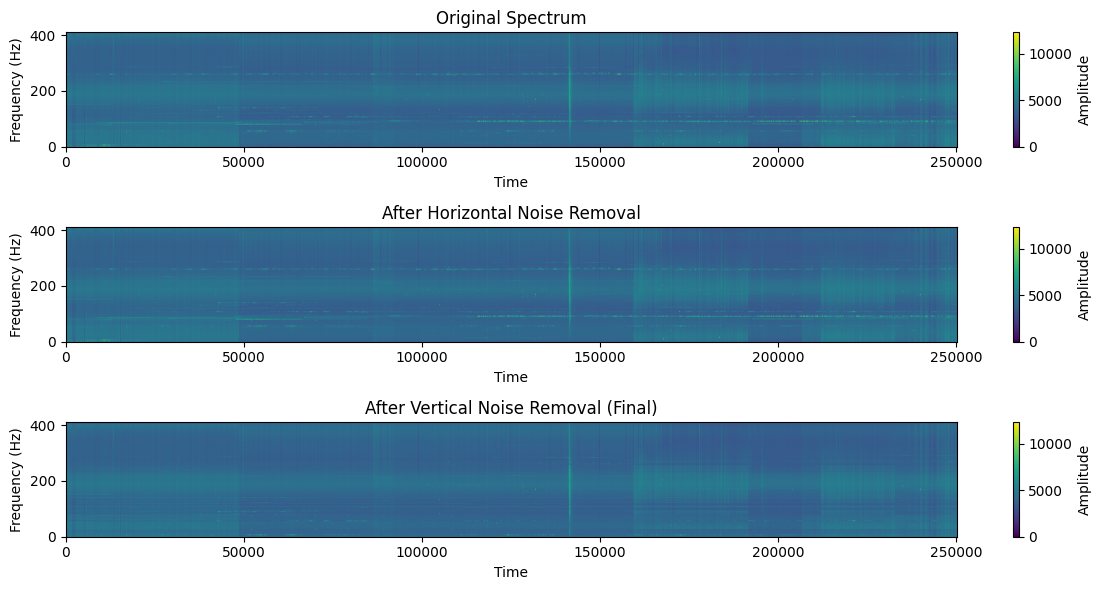

In [21]:
# Noise removal (same as original)
from data_denoise import remove_horizontal_noise, remove_vertical_noise

remove_horizontal_data = remove_horizontal_noise(data, num_std=15)
removed_data = remove_vertical_noise(remove_horizontal_data)

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.imshow(data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 2)
plt.imshow(remove_horizontal_data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('After Horizontal Noise Removal')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 3)
plt.imshow(removed_data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('After Vertical Noise Removal (Final)')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()


In [22]:
# Enhanced Labeling: Comparison between Traditional and Progressive Methods
from data_label import time_to_column_indices, create_srb_mask, apply_morphological_operations, apply_rolling_median_filter, intersect_srb_masks

start_time_str = '15:33:52'  # Replace with the actual onset time of your data
end_time_str = '15:35:47'    # Replace with the actual offset time of your data

start_index, end_index = time_to_column_indices(times, start_time_str, end_time_str)
print("start_index:", start_index, "end_index:", end_index)

# Method 1: Traditional approach (from original notebook)
print("\n=== Traditional Method ===")
initial_mask = create_srb_mask(removed_data, start_index, end_index, pct_threshold=50)
morph_mask = apply_morphological_operations(initial_mask, erosion_radius=20, dilation_radius=1, operation_sequence=['erode', 'dilate'])
traditional_mask = apply_rolling_median_filter(morph_mask, window_size=5)

undeniosed_mask = create_srb_mask(data, start_index, end_index)
undeniosed_morph_mask = apply_morphological_operations(undeniosed_mask, erosion_radius=2, dilation_radius=10, operation_sequence=['erode', 'dilate'])
undeniosed_filtered_mask = apply_rolling_median_filter(undeniosed_morph_mask, window_size=3)

final_traditional_mask = intersect_srb_masks(traditional_mask, undeniosed_filtered_mask)

print(f"Traditional method completed. Coverage: {np.sum(final_traditional_mask)/final_traditional_mask.size*100:.2f}%")


start_index: 140914 end_index: 142062

=== Traditional Method ===


/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/data_preprocessing/data_label.py:188: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  filtered_mask_df = mask_df.rolling(window=window_size, axis=0, center=True).median()


Traditional method completed. Coverage: 0.16%



=== Progressive Method ===
Progressive labeling for burst region: (1148, 411)
Stage 1: Conservative core detection...
  - Core regions found: 4
  - Total core coverage: 22.8%
Stage 2: Region growing from cores...
    Iteration 1: Added 10091 pixels
    Iteration 2: Added 8373 pixels
    Iteration 3: Added 7695 pixels
    Iteration 4: Added 7168 pixels
    Iteration 5: Added 6790 pixels
    Iteration 6: Added 6287 pixels
    Iteration 7: Added 5606 pixels
    Iteration 8: Added 5071 pixels
    Iteration 9: Added 4623 pixels
    Iteration 10: Added 3829 pixels
  - Expanded by 65533 pixels in 10 iterations
  - Total coverage after expansion: 36.6%
Stage 3: Boundary refinement...
  - Boundary refinement changed 1278 pixels
  - Final coverage: 36.6%
Progressive labeling completed. Final coverage: 36.6%
Progressive method completed. Coverage: 36.55%
Progressive mask shape: (1148, 411)
Traditional mask shape: (250183, 411)
Traditional burst mask shape: (1148, 411)
Progressive mask shape: (11

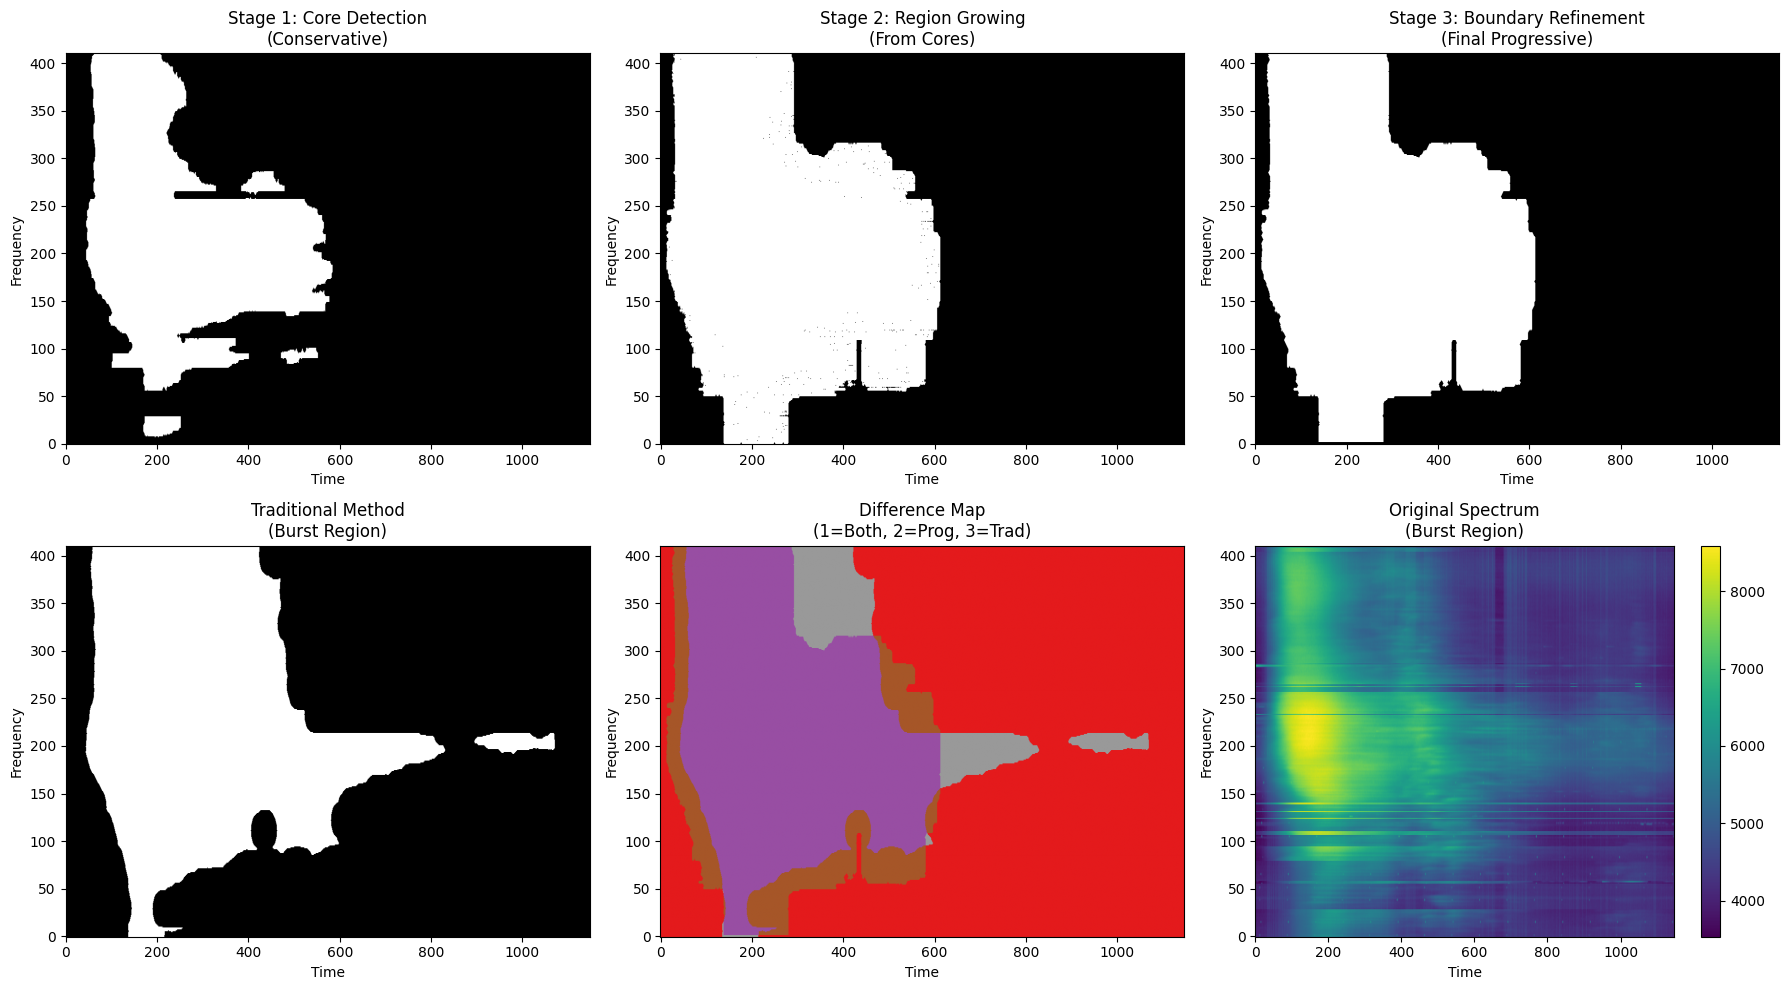

In [ ]:
# Method 2: Progressive labeling approach (NEW)
print("\n=== Progressive Method ===")

# Use the progressive labeling method
progressive_mask, stage_results = create_srb_mask_progressive(
    data=removed_data,
    start_index=start_index,
    end_index=end_index,
    use_progressive=True,
    conservative_percentile=75,  # High threshold for core detection
    expansion_percentile=40,     # Lower threshold for expansion
    min_core_area=150,          # Minimum core area
    save_intermediate=False
)

print(f"Progressive method completed. Coverage: {np.sum(progressive_mask)/progressive_mask.size*100:.2f}%")

# Debug shape information
print(f"Progressive mask shape: {progressive_mask.shape}")
print(f"Traditional mask shape: {final_traditional_mask.shape}")

# Ensure both masks have the same shape for comparison
# The progressive mask is from burst region only, traditional mask is full spectrum
# We need to extract the same region from traditional mask
traditional_burst_mask = final_traditional_mask[start_index:end_index, :]

print(f"Traditional burst mask shape: {traditional_burst_mask.shape}")
print(f"Progressive mask shape: {progressive_mask.shape}")

# Show stage-by-stage results in 2x3 layout
plt.figure(figsize=(18, 10))

# Top row: Progressive method stages
plt.subplot(2, 3, 1)
plt.imshow(stage_results['stage1_core'].T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Stage 1: Core Detection\n(Conservative)')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.imshow(stage_results['stage2_expanded'].T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Stage 2: Region Growing\n(From Cores)')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.imshow(stage_results['stage3_refined'].T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Stage 3: Boundary Refinement\n(Final Progressive)')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Bottom row: Traditional method, difference map, and original spectrum
plt.subplot(2, 3, 4)
plt.imshow(traditional_burst_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Traditional Method\n(Burst Region)')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Difference map - now using matching shapes
diff_map = np.zeros_like(progressive_mask, dtype=int)
diff_map[progressive_mask & traditional_burst_mask] = 1  # Both methods
diff_map[progressive_mask & ~traditional_burst_mask] = 2  # Progressive only
diff_map[traditional_burst_mask & ~progressive_mask] = 3  # Traditional only

plt.subplot(2, 3, 5)
plt.imshow(diff_map.T[::-1], aspect='auto', cmap='Set1', origin='lower')
plt.title('Difference Map\n(1=Both, 2=Prog, 3=Trad)')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Original spectrum (burst region)
plt.subplot(2, 3, 6)
original_burst_data = removed_data[(start_index):(end_index), :]
plt.imshow(original_burst_data.T[::-1], aspect='auto', cmap='viridis', origin='lower')
plt.title('Original Spectrum\n(Burst Region)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()

plt.tight_layout()
plt.show()


In [25]:
# Quantitative comparison of methods
print("\n=== Method Comparison Statistics ===")

# Calculate overlap and differences using burst region masks
overlap = np.sum(progressive_mask & traditional_burst_mask)
progressive_only = np.sum(progressive_mask & ~traditional_burst_mask)
traditional_only = np.sum(traditional_burst_mask & ~progressive_mask)
total_union = np.sum(progressive_mask | traditional_burst_mask)

print(f"Overlap pixels: {overlap}")
print(f"Progressive-only pixels: {progressive_only}")
print(f"Traditional-only pixels: {traditional_only}")


# Choose the best mask for subsequent processing
# For this example, let's use the progressive mask as it typically provides better quality
# But we need to create a full-size mask for slicing
using_mask_full = np.zeros_like(final_traditional_mask, dtype=bool)
using_mask_full[start_index:end_index, :] = progressive_mask
using_data = remove_horizontal_data

print(f"\nUsing progressive mask for slicing (burst region coverage: {np.sum(progressive_mask)/progressive_mask.size*100:.2f}%)")
print("Progressive mask selected as final mask!")



=== Method Comparison Statistics ===
Overlap pixels: 137399
Progressive-only pixels: 35059
Traditional-only pixels: 27477

Using progressive mask for slicing (burst region coverage: 36.55%)
Progressive mask selected as final mask!


In [26]:
# Data Slicing (same workflow as original, but using enhanced mask)
from data_slicing import SpectrogramSlicer

# Initialize the slicer (same as original)
slicer = SpectrogramSlicer(target_size=(256, 256), overlap_ratio=0.25, random_offset=False)

# Slice the spectrogram and mask using the progressive mask
slices, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=using_data.T[::-1],
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    mask=using_mask_full.T[::-1],  # Using progressive mask instead of traditional
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# Output slice information (same as original)
print(f"Generated {len(slices)} spectrogram slices")
print(f"Slice shape: {slices[0].shape}")
print(f"Mask slice shape: {mask_slices[0].shape}")
print(f"First few slice positions: {positions[:5]}")

# Quality assessment: count how many slices contain burst signal
burst_slices = 0
for mask_slice in mask_slices:
    if np.sum(mask_slice) > 0:
        burst_slices += 1

print(f"Slices containing burst signal: {burst_slices}/{len(slices)} ({burst_slices/len(slices)*100:.1f}%)")


Generated 16 spectrogram slices
Slice shape: (256, 256)
Mask slice shape: (256, 256)
First few slice positions: [(0, 140657), (155, 140657), (0, 140849), (155, 140849), (0, 141041)]
Slices containing burst signal: 8/16 (50.0%)


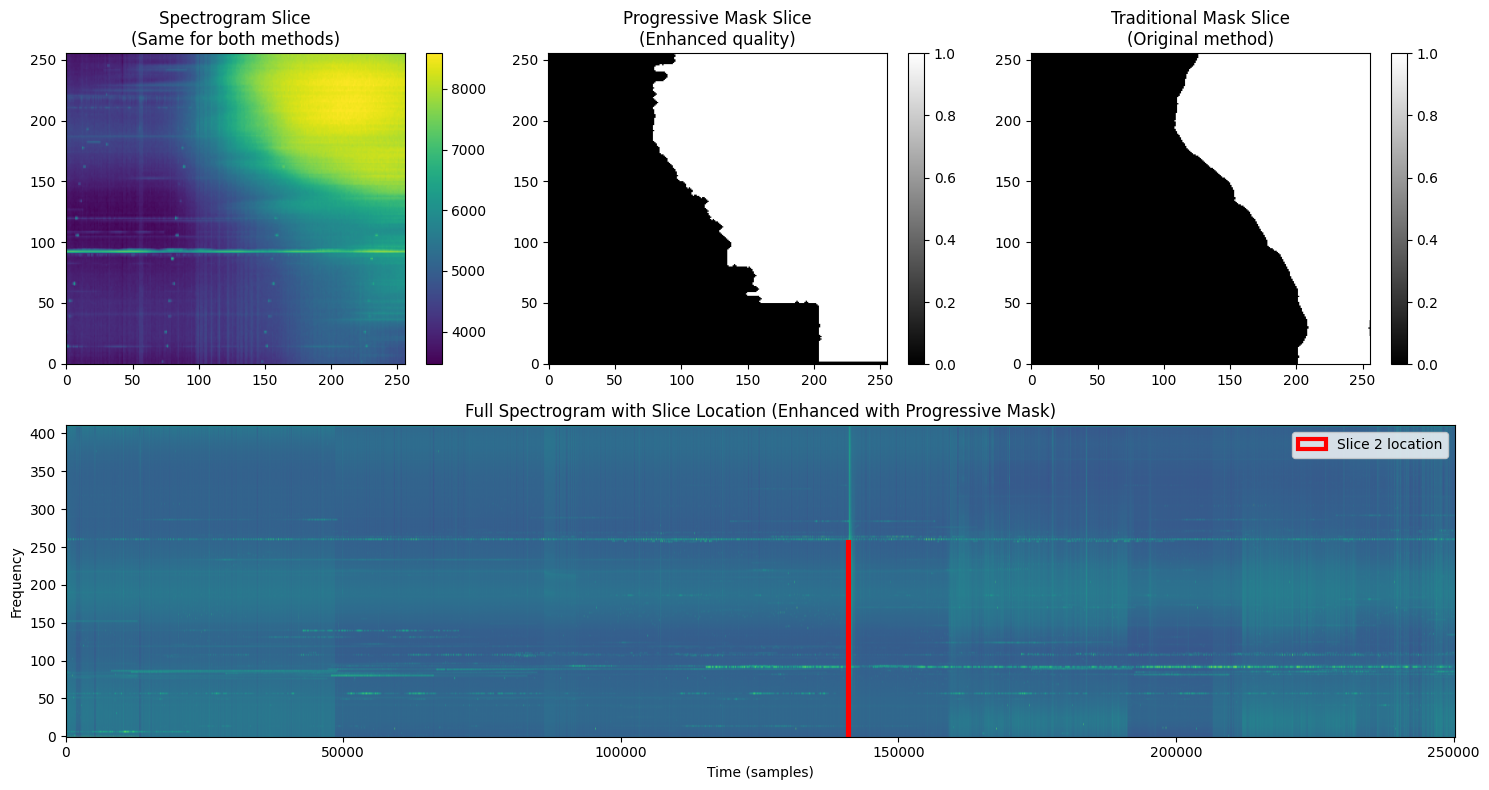


Slice 2 comparison:
  Progressive mask pixels: 32745
  Traditional mask pixels: 24824
  Difference: 7921 pixels


In [27]:
# Visualization (enhanced version with comparison)
from numpy import min, max

vmin = min(min(using_data))
vmax = max(max(using_data))

plt.figure(figsize=(15, 8))

# Compare slice quality between traditional and progressive masks
# Show traditional mask slice for comparison
traditional_slices, traditional_mask_slices, _ = slicer.slice_spectrogram_time_range(
    spectrogram=using_data.T[::-1],
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    mask=final_traditional_mask.T[::-1],  # Traditional mask
    time_padding=0.2,
    is_training=False
)

# Show comparison of slice 2
plt.subplot(2, 3, 1)
plt.imshow(slices[2], aspect='auto', cmap='viridis', origin='lower')
plt.title('Spectrogram Slice\n(Same for both methods)')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(mask_slices[2], aspect='auto', cmap='gray', origin='lower')
plt.title('Progressive Mask Slice\n(Enhanced quality)')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(traditional_mask_slices[2], aspect='auto', cmap='gray', origin='lower')
plt.title('Traditional Mask Slice\n(Original method)')
plt.colorbar()

# Show full spectrogram with slice location
plt.subplot(2, 1, 2)
plt.imshow(using_data.T[::-1], aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Full Spectrogram with Slice Location (Enhanced with Progressive Mask)')
plt.xlabel('Time (samples)')
plt.ylabel('Frequency')

if len(positions) > 0:
    y, x = positions[2]  # positions return (y, x)
    
    # Draw rectangle showing slice location
    rect = plt.Rectangle((x, y), 256, 256, 
                         linewidth=3, edgecolor='red', facecolor='none', 
                         label='Slice 2 location')
    plt.gca().add_patch(rect)
    plt.legend()

plt.tight_layout()
plt.show()

# Print comparison statistics for the shown slice
prog_pixels = np.sum(mask_slices[2])
trad_pixels = np.sum(traditional_mask_slices[2])
print(f"\nSlice 2 comparison:")
print(f"  Progressive mask pixels: {prog_pixels}")
print(f"  Traditional mask pixels: {trad_pixels}")
print(f"  Difference: {prog_pixels - trad_pixels} pixels")


In [ ]:
# Save slices to CSV files (same as original, but with enhanced metadata)
metadata = {
    'date': '20240420',  # change to the actual date!!!
    'start_time': start_time_str.replace(':', ''),
    'method': 'progressive',  # NEW: indicate labeling method used
    'conservative_percentile': 75,  # NEW: progressive labeling parameters
    'expansion_percentile': 40,
    'min_core_area': 150
}

save_dir = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices'
saved_files = slicer.save_slices_to_csv(
    slices=slices,
    mask_slices=mask_slices,
    save_dir=save_dir,
    naming_format='slice_{meta_date}_y{y}_x{x}_PeachMountain_new_method',  # Updated naming
    # !!! naming_format='slice_{meta_date}_y{y}_x{x}_{location}_new_masking_method'
    positions=positions,
    metadata=metadata
)

print(f"Saved {len(slices)} slices with progressive labeling to {save_dir}")

# Additional quality metrics for saved data
total_mask_pixels = sum(np.sum(mask_slice) for mask_slice in mask_slices)
total_pixels = len(mask_slices) * 256 * 256
coverage_ratio = total_mask_pixels / total_pixels

print(f"\nSaved slices quality metrics:")
print(f"  Total slices: {len(slices)}")
print(f"  Slices with signal: {burst_slices}")
print(f"  Overall mask coverage: {coverage_ratio*100:.2f}%")
print(f"  Average mask pixels per slice: {total_mask_pixels/len(mask_slices):.1f}")

# Save progressive labeling parameters for reproducibility
import json
params_file = os.path.join(save_dir, 'progressive_labeling_params.json')
with open(params_file, 'w') as f:
    json.dump({
        'conservative_percentile': 75,
        'expansion_percentile': 40,
        'min_core_area': 150,
        'start_time': start_time_str,
        'end_time': end_time_str,
        'start_index': int(start_index),
        'end_index': int(end_index),
        'total_slices': len(slices),
        'burst_slices': burst_slices,
        'coverage_ratio': float(coverage_ratio)
    }, f, indent=2)

print(f"Progressive labeling parameters saved to {params_file}")


In [ ]:
# Summary and recommendations
print("="*60)
print("ENHANCED DATA SLICING WITH PROGRESSIVE LABELING - SUMMARY")
print("="*60)

print(f"\n📊 DATA PROCESSING SUMMARY:")
print(f"   Original data shape: {data.shape}")
print(f"   Burst time range: {start_time_str} - {end_time_str}")
print(f"   Processing method: Progressive labeling + traditional slicing")

print(f"\n🎯 LABELING COMPARISON:")
print(f"   Traditional mask coverage (burst region): {np.sum(traditional_burst_mask)/traditional_burst_mask.size*100:.2f}%")
print(f"   Progressive mask coverage (burst region): {np.sum(progressive_mask)/progressive_mask.size*100:.2f}%")
print(f"   Method overlap: {overlap/max(total_union,1)*100:.2f}%")

print(f"\n📦 SLICING RESULTS:")
print(f"   Total slices generated: {len(slices)}")
print(f"   Slices with burst signal: {burst_slices} ({burst_slices/len(slices)*100:.1f}%)")
print(f"   Slice resolution: 256x256 pixels")
print(f"   Overlap ratio: 25%")

print(f"\n💾 SAVED OUTPUT:")
print(f"   Location: {save_dir}")
print(f"   Files saved: {len(saved_files)}")
print(f"   Naming pattern: slice_YYYYMMDD_yYYY_xXXXX_location_progressive.csv")

print(f"\n✨ PROGRESSIVE LABELING ADVANTAGES:")
print(f"   ✓ Multi-stage refinement (core → expansion → boundary)")
print(f"   ✓ Better noise vs. signal balance")
print(f"   ✓ Physical constraint validation")
print(f"   ✓ Detailed intermediate analysis available")
print(f"   ✓ Reproducible parameters saved")

print(f"\n🔧 NEXT STEPS:")
print(f"   1. Use saved slices for model training")
print(f"   2. Compare model performance: progressive vs traditional labels")
print(f"   3. Adjust progressive parameters based on domain expertise")
print(f"   4. Apply to additional datasets for validation")

print("="*60)
